# MusicBrainz place geocoder

This notebook loads a set of artists from musicbrainz, created by the [musicbrainz_downloader](musicbrainz_downloader.ipynb). Then it takes each's place name (ie, either where they're from or where they're most associated with - as determined in other notebook), and geocodes that place name to lat long. Then it maps the artists.

Nominatim API documentation: https://wiki.openstreetmap.org/wiki/Nominatim

Sample Nominatim query: https://nominatim.openstreetmap.org/search?format=json&q=brixton,london,england

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time, requests
from mpl_toolkits.basemap import Basemap
from geopy.distance import great_circle

%matplotlib inline
pause = 0.75

## Define geocoding functions

Nominatim and Google APIs

In [2]:
def geocode_nominatim(address):
    time.sleep(pause)
    url = u'https://nominatim.openstreetmap.org/search?format=json&q={}'
    request = url.format(address)
    response = requests.get(request)
    data = response.json()
    if len(data) > 0:
        return '{},{}'.format(data[0]['lat'], data[0]['lon'])

In [3]:
def geocode_google(address):
    time.sleep(pause)
    url = u'http://maps.googleapis.com/maps/api/geocode/json?sensor=false&address={}'
    request = url.format(address)
    response = requests.get(request)
    data = response.json()
    if len(data['results']) > 0:
        latitude = data['results'][0]['geometry']['location']['lat']
        longitude = data['results'][0]['geometry']['location']['lng']
        return '{},{}'.format(latitude, longitude)

## Test it

In [4]:
address = u"Brixton, London, England, United Kingdom"
latlng_google = geocode_google(address)
latlng_nominatim = geocode_nominatim(address)

In [5]:
print '{} google'.format(latlng_google)
print '{} nominatim'.format(latlng_nominatim)
print '{} miles apart'.format(round(great_circle(latlng_google, latlng_nominatim).miles, 2))

51.4612794,-0.1156148 google
51.4568044,-0.1167958 nominatim
0.31 miles apart


## Run it

In [6]:
artists = pd.read_csv('data/mb.csv', encoding='utf-8')
print '{:,} total artists'.format(len(artists))

# drop nans and get the unique set of places
addresses = pd.Series(artists['place_full'].dropna().sort_values().unique())
print '{:,} unique places'.format(len(addresses))

12,507 total artists
2,026 unique places


In [7]:
def get_country_if_more_detail(address):
    tokens = address.split(',')
    if len(tokens) > 1:
        return tokens[-1].strip()

# if a place contains only country name, check if that country name exists with more detail elsewhere in the list of places
# countries_with_more_detail is a list of all the countries that appear at end of comma-separated address strings
countries_with_more_detail = pd.Series(addresses.map(get_country_if_more_detail).dropna().sort_values().unique())
print '{:,} countries with more detail'.format(len(countries_with_more_detail))

# if so, discard the instance that is country name only - this country is represented elsewhere in list with finer grain info
# ie, keep 'estonia' if there is no 'talinn, estonia' elsewhere in list, 
# but discard 'russia' if 'moscow, russia' exists elsewhere in the list
addresses_to_geocode = addresses[~addresses.isin(countries_with_more_detail)]
print '{:,} unique addresses to geocode'.format(len(addresses_to_geocode))

91 countries with more detail
1,953 unique addresses to geocode


In [8]:
# geocode (with nominatim) each retained address (ie, full place name string)
start_time = time.time()

latlng_dict = {}
for address, n in zip(addresses_to_geocode, range(len(addresses_to_geocode))):
    if n % 10 == 0: print n,
    latlng_dict[address] = geocode_nominatim(address)

finish_time = time.time()

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950


In [9]:
print 'nominatim geocoded {:,} addresses in {:,} seconds'.format(len(addresses_to_geocode), int(finish_time-start_time))
print 'received {:,} non-null lat-longs'.format(len([key for key in latlng_dict if latlng_dict[key] is not None]))

nominatim geocoded 1,953 addresses in 2,947 seconds
received 1,857 non-null lat-longs


In [10]:
# which addresses failed to geocode successfully?
addresses_to_geocode = [ key for key in latlng_dict if latlng_dict[key] is None ]

In [11]:
# now geocode (with google) each address that failed with nominatim
if len(addresses_to_geocode) < 2500: #daily google request limit
    start_time = time.time()
    for address, n in zip(addresses_to_geocode, range(len(addresses_to_geocode))):
        if n % 10 == 0: print n,
        latlng_dict[address] = geocode_google(address)
    finish_time = time.time()

0 10 20 30 40 50 60 70 80 90


In [12]:
print 'google geocoded {:,} addresses in {:,} seconds'.format(len(addresses_to_geocode), int(finish_time-start_time))
print 'received {:,} non-null lat-longs'.format(len([key for key in latlng_dict if latlng_dict[key] is not None]))

google geocoded 96 addresses in 87 seconds
received 1,951 non-null lat-longs


In [13]:
# for each artist, if their place appears in the geocoded dict, pull the latlng value from dict into new df column
def get_latlng_by_address(address):
    try:
        return latlng_dict[address]
    except:
        return None

artists['place_latlng'] = artists['place_full'].map(get_latlng_by_address)
artists[['name', 'place_full', 'place_latlng']].sort_values(by='place_full').head()

,name,place_full,place_latlng
8005,Triángulo de Amor Bizarro,"A Coruña, A Coruña, Galicia, Spain","43.3712091,-8.3958767"
7227,Leæther Strip,"Aalborg, Aalborg Municipality, North Denmark R...","57.0482206,9.9193939"
11718,Tina Dickow,"Aarhus, Aarhus Municipality, Central Denmark R...","56.1496278,10.2134046"
10150,Godless Wicked Creeps,"Aarhus, Aarhus Municipality, Central Denmark R...","56.1496278,10.2134046"
7385,Spleen United,"Aarhus, Aarhus Municipality, Central Denmark R...","56.1496278,10.2134046"


In [14]:
artists.to_csv('data/mb_geocoded.csv', index=False, encoding='utf-8')

## Map it

In [15]:
# get discrete vectors of lats and lons, for easy x-y scatter-plotting
lats = artists['place_latlng'].dropna().map(lambda x: float(x.split(',')[0]))
lons = artists['place_latlng'].dropna().map(lambda x: float(x.split(',')[1]))

In [16]:
# define map colors
land_color = '#f5f5f3'
water_color = '#cdd2d4'
coastline_color = '#f5f5f3'
border_color = '#bbbbbb'
meridian_color = '#f5f5f3'
marker_fill_color = 'r'
marker_edge_color = 'None'

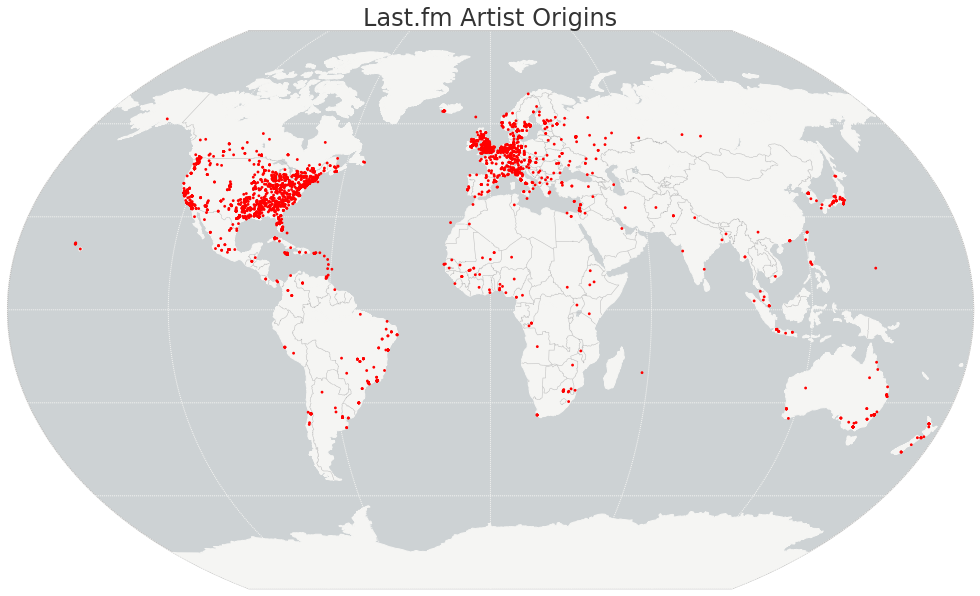

In [17]:
# create the plot
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, axisbg='#ffffff', frame_on=False)
ax.set_title('Last.fm Artist Origins', fontsize=24, color='#333333')

# draw the basemap and its features
m = Basemap(projection='kav7', lon_0=0, resolution='l', area_thresh=10000)
m.drawmapboundary(color=border_color, fill_color=water_color)
m.drawcoastlines(color=coastline_color)
m.drawcountries(color=border_color)
m.fillcontinents(color=land_color, lake_color=water_color)
m.drawparallels(np.arange(-90., 120., 30.), color=meridian_color)
m.drawmeridians(np.arange(0., 420., 60.), color=meridian_color)

# project our points from each dataset then concatenate and scatter plot them
x, y = m(lons.values, lats.values)
m.scatter(x, y, s=8, color=marker_fill_color, edgecolor=marker_edge_color, alpha=1, zorder=3)

# show the map
plt.savefig('images/lastfm_artists_origins_map.png', dpi=96, bbox_inches='tight', pad_inches=0.2)
plt.show()